## Basic ARIMA:
As implied by its shortened acronym, the pure ARIMA model-building methodology employs only lagged values of the dependent variable (i.e., AR terms) and lagged values of errors previously produced by the model (i.e., MA terms). The I in ARIMA refers to integrated and indicates that the dependent variable time series has been differenced one or more times to make the time series stationary before model building begins.

## Introduction to ARIMAX:
An Autoregressive Integrated Moving Average with Explanatory variable (ARIMAX) model is basically an ARIMA model with one or more explanatory/independent variables also known as Exogenous variables.

## Parameters in ARIMAX:
There are basically 3 parameters in an ARIMAX model: p,d,q Values of p and q are determined based on the autocorrelation and partial autocorrelation plots and the value of d depends on the level of stationarity in the data. In PACF plot, the number of spikes, above a certain reference line, decide the value of p. In ACF plot, the number of spikes, above a certain reference line, decide the value of q. For example: ARIMAX(2,1,1) means that we have a second order autoregressive model with first order moving average component and the series has been differenced once to make it stationary.

Let us take a sample dataset of sales and try to understand how ARIMAX works.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm

In [20]:
df_sales = pd.read_csv('../tables/all_data/Yingkou_Ningbo_deals.csv')
df_fr = pd.read_csv('../tables/all_data/Yingkou_Ningbo_AMT.csv')
df = pd.DataFrame()
df['date'] = df_sales['WBL_AUD_DT']
df['sales'] = df_sales['deals']
df['fr'] = df_fr['AMT']
df

,date,sales,fr
0,2019/9/19,243,1834.350000
1,2019/9/20,21,1985.350000
2,2019/9/21,45,1934.100000
3,2019/9/22,309,1934.100000
4,2019/9/23,54,1934.100000
5,2019/9/24,55,1934.100000
6,2019/9/25,76,1934.100000
7,2019/9/26,57,1946.073684
8,2019/9/27,187,1938.114706
9,2019/9/28,54,1939.155556


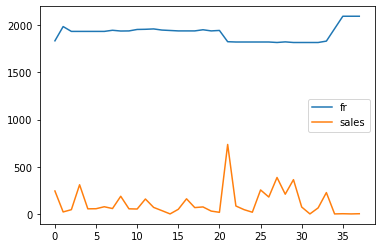

In [21]:
df[['fr','sales']].plot()
plt.show()

In [8]:
print(sm.tsa.stattools.grangercausalitytests(df[['sales','fr']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8044  , p=0.1881  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=1.9636  , p=0.1611  , df=1
likelihood ratio test: chi2=1.9133  , p=0.1666  , df=1
parameter F test:         F=1.8044  , p=0.1881  , df_denom=34, df_num=1
{1: ({'ssr_ftest': (1.804390782767244, 0.18808053142597791, 34.0, 1), 'ssr_chi2test': (1.9636017341878833, 0.16112864274193567, 1), 'lrtest': (1.9132703268293767, 0.1666004375432049, 1), 'params_ftest': (1.8043907827672279, 0.18808053142597936, 34.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f91745519d0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9174693fd0>, array([[0., 1., 0.]])])}


In [9]:
print(sm.tsa.stattools.grangercausalitytests(df[['fr','sales']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1056  , p=0.7472  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.1149  , p=0.7346  , df=1
likelihood ratio test: chi2=0.1147  , p=0.7348  , df=1
parameter F test:         F=0.1056  , p=0.7472  , df_denom=34, df_num=1
{1: ({'ssr_ftest': (0.10559350803803777, 0.7472088499297476, 34.0, 1), 'ssr_chi2test': (0.11491058227668816, 0.7346213056531539, 1), 'lrtest': (0.11473251246371774, 0.7348192556612347, 1), 'params_ftest': (0.10559350803799407, 0.7472088499298046, 34.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9173f8cd10>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9173f8ce10>, array([[0., 1., 0.]])])}


## here is the full blown code for the correct ARIMAX model.

In [22]:
df['difffr'] = df["fr"].diff()
df['lag']=df['difffr'].shift()
df.dropna(inplace=True)
df

,date,sales,fr,difffr,lag
2,2019/9/21,45,1934.100000,-51.250000,151.000000
3,2019/9/22,309,1934.100000,0.000000,-51.250000
4,2019/9/23,54,1934.100000,0.000000,0.000000
5,2019/9/24,55,1934.100000,0.000000,0.000000
6,2019/9/25,76,1934.100000,0.000000,0.000000
7,2019/9/26,57,1946.073684,11.973684,0.000000
8,2019/9/27,187,1938.114706,-7.958978,11.973684
9,2019/9/28,54,1939.155556,1.040850,-7.958978
10,2019/9/29,52,1954.696154,15.540598,1.040850
11,2019/9/30,158,1956.495570,1.799416,15.540598


In [27]:
model=sm.tsa.ARIMA(endog=df['sales'], exog=df[['lag']], order=[6,1,0])
results=model.fit()
print(results.summary())

/Users/mingxulu/opt/anaconda3/envs/anl/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/mingxulu/opt/anaconda3/envs/anl/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                   35
Model:                 ARIMA(6, 1, 0)   Log Likelihood                -225.712
Method:                       css-mle   S.D. of innovations            149.814
Date:                Tue, 23 Feb 2021   AIC                            469.425
Time:                        11:08:07   BIC                            483.423
Sample:                       

/Users/mingxulu/opt/anaconda3/envs/anl/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/mingxulu/opt/anaconda3/envs/anl/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:827: SpecificationWarning: 
The number of observations in exog does not match the number of out-of-sample
observations.  This might indicate that exog is not correctly aligned. exog
should be aligned so that the exog[0] is used for the first out-of-sample
forecast, and exog[-1] is used for the last out-of-sample forecast.
exog is not used for in-sample observations which are the fitted values.

To silence this warning, ensure the number of observation in exog (42)
matches the number of out-of-sample forecasts (1)'

  warnings.warn(msg, SpecificationWarning)
/Users/mingxulu/opt/anaconda3/envs/anl/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

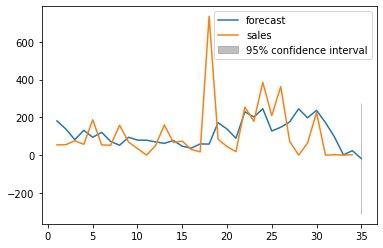

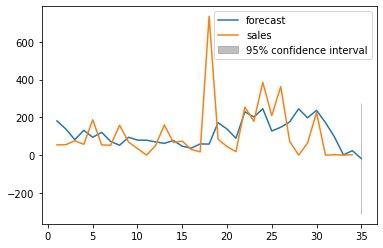

In [31]:
results.plot_predict(2,36,exog=df['lag'])